# Credit card applications

## 1. Import libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
df = pd.read_csv("datasets/cc_approvals.data", header=None)

df.head(n=5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


## 2. Inspecting the applications
<p>The output may appear a bit confusing at its first sight, but let's try to figure out the most important features of a credit card application. The features of this dataset have been anonymized to protect the privacy, but <a href="http://rstudio-pubs-static.s3.amazonaws.com/73039_9946de135c0a49daa7a0a9eda4a67a72.html">this blog</a> gives us a pretty good overview of the probable features. The probable features in a typical credit card application are <code>Gender</code>, <code>Age</code>, <code>Debt</code>, <code>Married</code>, <code>BankCustomer</code>, <code>EducationLevel</code>, <code>Ethnicity</code>, <code>YearsEmployed</code>, <code>PriorDefault</code>, <code>Employed</code>, <code>CreditScore</code>, <code>DriversLicense</code>, <code>Citizen</code>, <code>ZipCode</code>, <code>Income</code> and finally the <code>ApprovalStatus</code>. This gives us a pretty good starting point, and we can map these features with respect to the columns in the output.   </p>
<p>As we can see from our first glance at the data, the dataset has a mixture of numerical and non-numerical features. This can be fixed with some preprocessing, but before we do that, let's learn about the dataset a bit more to see if there are other dataset issues that need to be fixed.</p>

### Describe

In [3]:
print('Quatity features')
display(df.describe())

print('\nQuanlity features')
df.describe(include=['O'])

Quatity features


,2,7,10,14
count,690.000000,690.000000,690.00000,690.000000
mean,4.758725,2.223406,2.40000,1017.385507
std,4.978163,3.346513,4.86294,5210.102598
min,0.000000,0.000000,0.00000,0.000000
25%,1.000000,0.165000,0.00000,0.000000
50%,2.750000,1.000000,0.00000,5.000000
75%,7.207500,2.625000,3.00000,395.500000
max,28.000000,28.500000,67.00000,100000.000000



Quanlity features


,0,1,3,4,5,6,8,9,11,12,13,15
count,690,690,690,690,690,690,690,690,690,690,690,690
unique,3,350,4,4,15,10,2,2,2,3,171,2
top,b,?,u,g,c,v,t,f,f,g,00000,-
freq,468,12,519,519,137,399,361,395,374,625,132,383


### Information

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    object 
 1   1       690 non-null    object 
 2   2       690 non-null    float64
 3   3       690 non-null    object 
 4   4       690 non-null    object 
 5   5       690 non-null    object 
 6   6       690 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-null    object 
 9   9       690 non-null    object 
 10  10      690 non-null    int64  
 11  11      690 non-null    object 
 12  12      690 non-null    object 
 13  13      690 non-null    object 
 14  14      690 non-null    int64  
 15  15      690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


## 3. Preprocessing data


#### Splitting data
<p>Now, we will split our data into train set and test set to prepare our data for two different phases of machine learning modeling: training and testing. Ideally, no information from the test data should be used to preprocess the training data or should be used to direct the training process of a machine learning model. Hence, we first split the data and then preprocess it.</p>

In [5]:
X, y = df.iloc[:, :-1], df.iloc[:, [-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### Feature selection
<p>Firstly, features like <code>DriversLicense</code> and <code>ZipCode</code> are not as important as the other features in the dataset for predicting credit card approvals. To get a better sense, we can measure their <a href="https://realpython.com/numpy-scipy-pandas-correlation-python/">statistical correlation</a> to the labels of the dataset. But this is out of scope for this project. We should drop them to design our machine learning model with the best set of features. In Data Science literature, this is often referred to as <em>feature selection</em>. </p>

In [6]:
class ColDropper(BaseEstimator, TransformerMixin):
    def __init__(self, dropAttributes):
        self.dropAttributes = dropAttributes

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        return X.drop(self.dropAttributes, axis=1)

#### Building preprocessing pipeline
As we can see that there is no missing value but missing values in this datasets is represented by a question mark ('?'). Therefore, we have to handle it before passing data into machine learning model.  

**Categorical attributes**:
- Filling missing value with the most frequently value.
- Convert them into numeric attribute by `OnehotEncoding`

**Numerical attributes**:
- Filling missing value with the *mean* 
- Scaling data into a uniform range

Besides, the we have to convert the target variable `y` into numerical by map `+` value to 1 and the other is 0

In [7]:
class convert2TrulyMissing(BaseEstimator, TransformerMixin):
    def __init__(self, missing_label):
        self.missing_label = missing_label

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.replace(self.missing_label, np.nan)

In [8]:
cat_attrs = X.select_dtypes(include=['O']).columns.tolist()
cat_attrs.remove(11)
cat_attrs.remove(13)
cat_attrs[-1] = 11
cat_preprocess = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                               OneHotEncoder(handle_unknown='ignore'))

num_attrs = X.select_dtypes(exclude=['O']).columns.tolist()
num_attrs[-1] = 12
num_proprocess = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'),
                               MinMaxScaler())

fill_missing = make_column_transformer((cat_preprocess, cat_attrs),
                                       (num_proprocess, num_attrs))

preprocess_pipeline = make_pipeline(ColDropper(dropAttributes=[11, 13]),
                                    convert2TrulyMissing(missing_label='?'),
                                    fill_missing)

preprocess_pipeline

Pipeline(steps=[('coldropper', ColDropper(dropAttributes=[11, 13])),
                ('convert2trulymissing',
                 convert2TrulyMissing(missing_label='?')),
                ('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 3, 4, 5, 6, 8, 9, 11]),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  [2, 7, 10, 12])]))])

## Model selection:

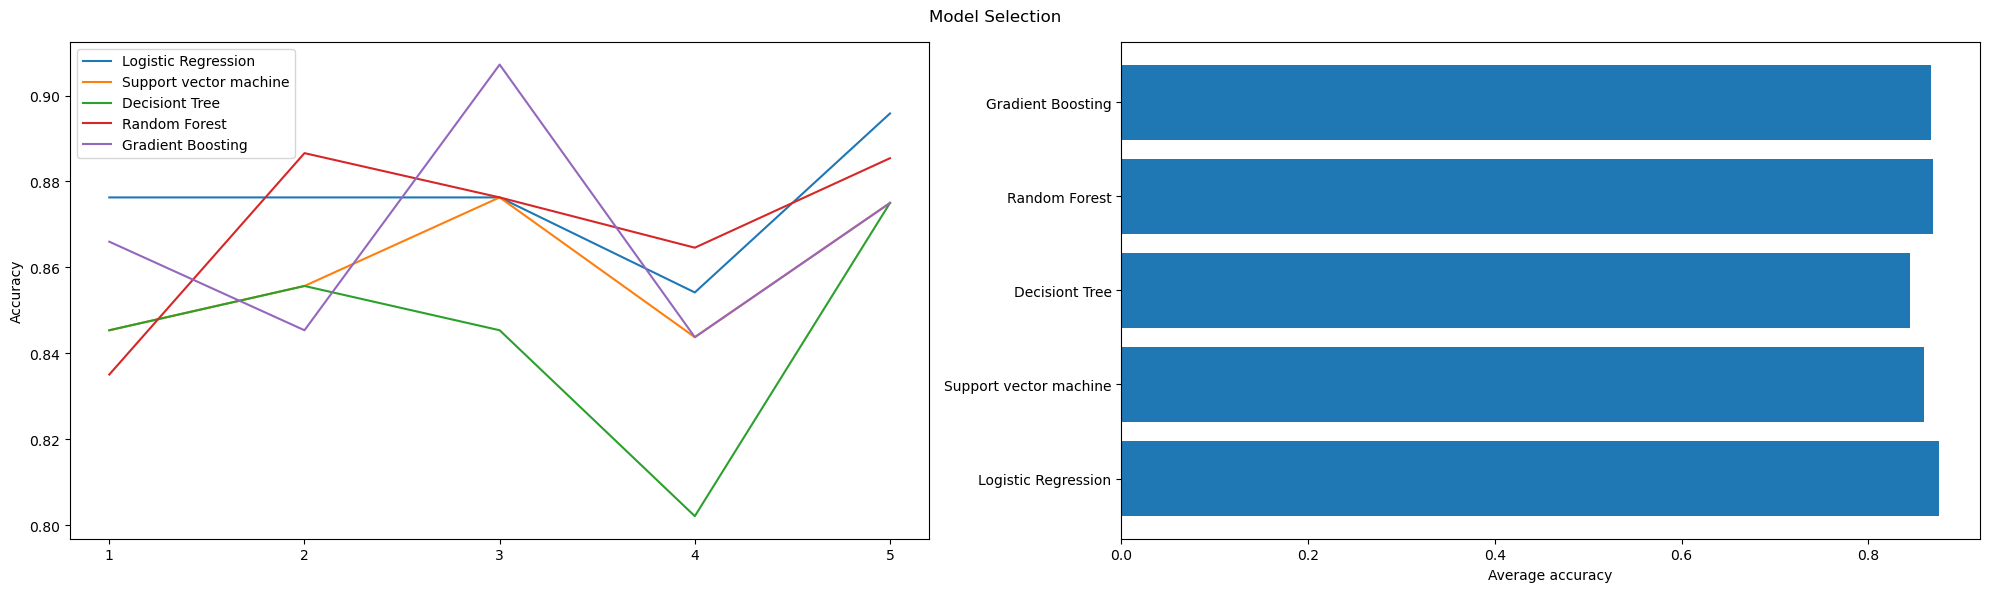

In [9]:
models = {'Logistic Regression': LogisticRegression(),
          'Support vector machine': SVC(),
          'Decisiont Tree': DecisionTreeClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Gradient Boosting': GradientBoostingClassifier()}

fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(20, 6))
mean_scores = {}
for k, v in models.items():
    pipeline = make_pipeline(preprocess_pipeline, v)
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    ax0.plot(list(range(1, 6)), scores)

    mean_scores[k] = scores

ax0.set_xticks(list(range(1, 6)))
ax0.set_ylabel('Accuracy')
ax0.legend(models.keys())

mean_scores = pd.DataFrame(mean_scores).mean()
ax1.barh(mean_scores.index, mean_scores.values)

ax1.set_xlabel('Average accuracy')

fig.suptitle('Model Selection')
fig.tight_layout()
plt.show()

&rarr; Select ***Random Forest*** model

## Fine-tune model

In [10]:
rf = RandomForestClassifier()
pipeline = make_pipeline(preprocess_pipeline, rf)

pipeline.fit(X_train, y_train)
print('Accuracy score of default model:', accuracy_score(pipeline.predict(X_test), y_test))

Accuracy score of default model: 0.8502415458937198


In [11]:
fineTune = GridSearchCV(pipeline, {'randomforestclassifier__n_estimators': [10, 50, 100, 200],
                                         'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss'],
                                         'randomforestclassifier__max_depth': [10, 30, 50, 100],
                                         'randomforestclassifier__min_samples_split': [3, 6, 10]},
                                         scoring='accuracy',
                                         cv=5)
fineTune.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('coldropper',
                                                         ColDropper(dropAttributes=[11,
                                                                                    13])),
                                                        ('convert2trulymissing',
                                                         convert2TrulyMissing(missing_label='?')),
                                                        ('columntransformer',
                                                         ColumnTransformer(transformers=[('pipeline-1',
                                                                                          Pipeline(steps=[('simpleimputer',
                                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                                          ('onehotencoder',
                                                                                                           OneHo...
                                                                                                          ('minmaxscaler',
                                                                                                           MinMaxScaler())]),
                                                                                          [2,
                                                                                           7,
                                                                                           10,
                                                                                           12])]))])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__criterion': ['gini',
                                                               'entropy',
                                                               'log_loss'],
                         'randomforestclassifier__max_depth': [10, 30, 50, 100],
                         'randomforestclassifier__min_samples_split': [3, 6,
                                                                       10],
                         'randomforestclassifier__n_estimators': [10, 50, 100,
                                                                  200]},
             scoring='accuracy')

In [12]:
final_model = fineTune.best_estimator_
print('Accuracy of best model:', accuracy_score(final_model.predict(X_test), y_test))

Accuracy of best model: 0.8357487922705314
